In [1]:
import sys
sys.path.append('/vera/u/olwitt/illustris_python/illustris_python')
from loadMPBs import loadMPBs

import time
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import h5py
import numba as nb
from numba import jit, njit
import tracerFuncs as tF
import plotFuncs as pF

import funcs
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

plt.style.use('default')
plt.rcParams["figure.figsize"][0] = 16
plt.rcParams["figure.figsize"][1] = 9
plt.rcParams['errorbar.capsize']=2

In [2]:
basePath='/virgotng/universe/IllustrisTNG/TNG50-4/output'
h_const=il.groupcat.loadHeader(basePath,99)['HubbleParam']
boxSize = il.groupcat.loadHeader(basePath,99)['BoxSize']
print(h_const)

0.6774


# where is tracer parent?

find out, where the tracer parent sits, i.e. whether it's still in the main progenitor or in another galaxy or in the IGM

In [3]:
def binning(location, isInMP,help_offsets, mass_bin1, mass_bin2, mass_bin3, mass_bin4, mass_bin5):
    res = np.zeros((5,3))
    gal_res = np.zeros((help_offsets.shape[0] - 1,3))
    
    #determine mass fractions for every galaxy individually
    for i in nb.prange(0,help_offsets.shape[0] - 1):
        indices = np.arange(help_offsets[i],help_offsets[i+1])
        gal_res[i,0] = np.where(isInMP[indices])[0].shape[0]
        gal_res[i,1] = np.where(location[indices] != -1)[0].shape[0] #other galaxies 
        gal_res[i,1] -= gal_res[i,0] #subtract number of parents in mp from number in other galaxies
        gal_res[i,2] = indices.shape[0] #total
        gal_res[i,:2] = gal_res[i,:2] / gal_res[i,2] if gal_res[i,2] > 0 else gal_res[i,:2] #obtain mass fractions
    
    #determine mass fractions for entire mass bins
    for i in nb.prange(5):
        mass_bin = mass_bin1 if i==0 else mass_bin2 if i==1 else mass_bin3 if i==2 else mass_bin4 if i==3 else\
        mass_bin5
        indices = np.nonzero(funcs.isin(location,mass_bin))[0]
        res[i,0] = np.where(isInMP[indices])[0].shape[0] #mp in mass bin
        res[i,1] = indices.shape[0] #other galaxies in mass bin
        res[i,2] = np.sum(res[i,:2]) #total in mass bin
        res[i,1] -= res[i,0] #subtract number of parents in mp from number in other galaxies
    return res, gal_res

In [25]:
def location_of_parents(parent_index_filename, basePath, start_snap, target_snap, tree_ids,\
                        parent_indices, help_offsets, sub_ids, starsInSubOffset_target_snap, gasInSubOffset_target_snap,\
                        numInSub_target_snap, random_frac = 1):
    """first output returns the subhalo index if the tracer parent particle sits in a galaxy or -1 if it's in the IGM
    second output states, whether parent particle is inside main progenitor at target snapshot"""
    
    assert random_frac > 0 and random_frac <= 1, 'random fraction has to be > 0 and <= 1!'
    #load number of particles per galaxy to avoid classifying parents as bound to a galaxy 
    #while they're in reality "inner fuzz" of a halo
    
    gasNumInSub_target_snap = numInSub_target_snap[:,0].copy()
    starNumInSub_target_snap = numInSub_target_snap[:,4].copy()
    del numInSub_target_snap
    
    #for resoltution comparison reasons: only use <random_frac> fraction of all tracers:
    rng = np.random.default_rng()
    random_parent_indices = np.zeros(parent_indices.shape)
    new_help_offsets = np.zeros(help_offsets.shape[0]).astype(int)
    if random_frac < 1:
        for i in range(0, help_offsets.shape[0] - 1):
            indices = np.arange(help_offsets[i],help_offsets[i+1])
            size = int(indices.size * random_frac)
            new_help_offsets[i+1] = size + new_help_offsets[i]
            if size > 0:
                parent_indices_indices = rng.choice(indices, size, replace = False, shuffle = False).astype(int)
                random_parent_indices[new_help_offsets[i]:new_help_offsets[i+1]] =\
                parent_indices[np.sort(parent_indices_indices)]
    
        help_offsets = new_help_offsets.copy()
        not_zero = np.where(random_parent_indices[:,0] != 0)[0]
        random_parent_indices = random_parent_indices[not_zero,:]
        parent_indices = random_parent_indices.copy()

        assert parent_indices.shape[0] == new_help_offsets[-1]
        
        del random_parent_indices, new_help_offsets
        
    #find parent index in offset files in NlogM
    location = pF.searchsorted_gas_stars(parent_indices, gasInSubOffset_target_snap, gasNumInSub_target_snap,\
                                               starsInSubOffset_target_snap, starNumInSub_target_snap)
    
    print(location[help_offsets[10482]:help_offsets[10483]])
    print(np.where(location[help_offsets[10482]:help_offsets[10483]] == -1)[0])
    
    #now identify parents that are still in their (main progenitor) galaxy
    
    isInMP = np.empty(parent_indices.shape[0],dtype = bool)
    isInMP.fill(False)
    tree_check = list(tree_ids)
    
    #determine missing trees:
    missing = []
    counter = 0
    
    for i in range(sub_ids[-1]):
        if i != tree_check[counter]:
            missing.append(i)
            i += 1
            continue
        counter += 1
    
    test = 0
    for j in nb.prange(0,help_offsets.shape[0] - 1): #loop over all relevant galaxies at z=0
        #find all associated particles:
        parentIndicesInSub = np.arange(help_offsets[j],help_offsets[j + 1]).astype(int)
        
        if j in missing or parentIndicesInSub.size == 0: #if subhalo hast no tree, skip it and assign "False"
            if j in missing:
                test += parentIndicesInSub.size
            continue
        if tree_ids[sub_ids[j]]['SubfindID'].shape[0] <= start_snap - target_snap: #if tree doesn't reach until target_snap
            test += parentIndicesInSub.size            
            continue
            
        main_prog = tree_ids[sub_ids[j]]['SubfindID'][start_snap - target_snap]
        where = np.where(location[parentIndicesInSub] == main_prog)[0] + parentIndicesInSub[0]
        isInMP[where] = True

        print('main progenitor: ', main_prog)
        print(location[parentIndicesInSub][:10],location[parentIndicesInSub][-10:])
        
        if target_snap == 99:
            assert (np.where(location[parentIndicesInSub] == main_prog)[0].shape[0]) == parentIndicesInSub.shape[0],\
            'offsets wrong probably'    
    
    return location, isInMP, help_offsets

In [34]:
def fracs_w_mass_bins(basePath, sub_ids, start_snap = 99, random_frac = 1):
    start = time.time()
    h_const = il.groupcat.loadHeader(basePath, start_snap)['HubbleParam']

    num_subs = il.groupcat.loadSubhalos(basePath, start_snap, fields = ['SubhaloMass']).shape[0]
    
    #load all MPBs
    tree_ids = loadMPBs(basePath,start_snap,ids = np.arange(num_subs), fields=['SubfindID'])
    
    snap = np.arange(99,1,-1)
    
    n = snap.size
    
    z = np.zeros(n)
    
    mp = np.zeros(n)
    igm = np.zeros(n)
    sub = np.zeros(n)
    total = np.zeros(n)

    nums = np.zeros((n,5,3))
    
    gal_comp = np.zeros((n,sub_ids.shape[0],3)) #galaxy composition

    #necessary offsets, when not every tracer is important:
    insituStarsInSubOffset = tF.insituStarsInSubOffset(basePath, start_snap)
    f = h5py.File('files/' + basePath[32:39] + '/all_parent_indices.hdf5','r')
    parent_indices = f[f'snap_099/parent_indices'][:,0]
    num_tracers = parent_indices.shape[0]
    del parent_indices
    
    #check, whether old variable names are used
    if f.__contains__(f'snap_0{start_snap}/numTracersInParents'):
        numTracersInParents = f[f'snap_0{start_snap}/numTracersInParents'][:]
    else:
        numTracersInParents = f[f'snap_0{start_snap}/tracers_in_parents_offset'][:]
    
    parentsInSubOffset = tF.tracersInSubhalo(insituStarsInSubOffset,numTracersInParents).astype(int)
    parentsInSubOffset  = np.insert(parentsInSubOffset, 0, 0)
    #print('parents in sub offsets: ',parentsInSubOffset[:10])
    
    help_offsets = np.zeros(sub_ids.shape[0])
    
    which_indices = np.zeros(num_tracers)
    
    before_indices = time.time()
    counter = 0
    
    for i in range(1,sub_ids.shape[0] + 1):
        indcs = np.arange(parentsInSubOffset[sub_ids[i-1]],parentsInSubOffset[sub_ids[i-1]+1])
        which_indices[counter:counter + indcs.shape[0]] = indcs
        help_offsets[i-1] = indcs.shape[0]
        counter += indcs.shape[0]
        
    del indcs#, parentsInSubOffset
        
    #trim zeros at the end:
    which_indices = np.trim_zeros(which_indices,'b').astype(int)
    
    #compute correct offsets:
    ## states, which indices correspond to which subhalo from sub_ids
    help_offsets = np.cumsum(help_offsets).astype(int)
    help_offsets = np.insert(help_offsets,0,0)
    
    if funcs.areEqual(sub_ids, np.arange(num_subs)):
        assert funcs.areEqual(help_offsets, parentsInSubOffset), 'when all subhalos are considered, help_offsets and\
                                                                    parentsInSubOffset must be equal'
        print('they are equal', flush = True)
    
    start_loop = time.time()
    print('time for indices: ',start_loop-before_indices, flush = True)
    print('before loop: ',start_loop-start, flush = True)
    
    for i in range(n):
        parent_indices = f[f'snap_0{snap[i]}/parent_indices'][:,:]
        
        #only consider indices of relevant galaxies        
        parent_indices = parent_indices[which_indices,:]
        
        if(i==0):
            end_files = time.time()
            print('time for loading snap from files: ',end_files-start_loop, flush = True)
        
            
        if snap[i] < 10:
            str_snap = f'0{snap[i]}'
        else:
            str_snap = str(snap[i])
        
        g = h5py.File(basePath[:-6] + 'postprocessing/offsets/offsets_0' + str_snap + '.hdf5','r')
        starsInSubOffset_target_snap = g['Subhalo/SnapByType'][:,4]
        gasInSubOffset_target_snap = g['Subhalo/SnapByType'][:,0]
        g.close()
        
        numInSub_target_snap = il.groupcat.loadSubhalos(basePath, snap[i],fields=['SubhaloLenType'])
        before_locating = time.time()
        
        #run function to determine location of parents
        location, isInMP, new_help_offsets =\
        location_of_parents('files/' + basePath[32:39] + '/all_parent_indices.hdf5', basePath, start_snap = 99,\
                            target_snap = snap[i], tree_ids = tree_ids, parent_indices = parent_indices,\
                            help_offsets = help_offsets, sub_ids = sub_ids, starsInSubOffset_target_snap =\
                            starsInSubOffset_target_snap, gasInSubOffset_target_snap = gasInSubOffset_target_snap,\
                           numInSub_target_snap = numInSub_target_snap, random_frac = random_frac)

        if(i==0):
            end_locate = time.time()
            print('total time for locating: ',end_locate-before_locating, flush = True)
        #load stellar masses
        sub_masses_stars = il.groupcat.loadSubhalos(basePath,snap[i],fields=['SubhaloMassType'])[:,4] * 1e10/h_const
        sub_masses_gas = il.groupcat.loadSubhalos(basePath,snap[i],fields=['SubhaloMassType'])[:,0] * 1e10/h_const
        sub_masses = sub_masses_stars + sub_masses_gas #consider baryonic mass, not stellar mass
        
        m_tot = np.sum(sub_masses)
        
        #create mass bins
        mass_bin1 = np.where(np.logical_and(sub_masses != 0, sub_masses < 1e9))[0]
        mass_bin2 = np.where(np.logical_and(sub_masses >= 1e9, sub_masses < 1e10))[0]
        mass_bin3 = np.where(np.logical_and(sub_masses >= 1e10, sub_masses < 1e11))[0]
        mass_bin4 = np.where(np.logical_and(sub_masses >= 1e11, sub_masses < 1e12))[0]
        mass_bin5 = np.where(sub_masses >= 1e12)[0]
        
        norm = np.zeros(5)
        
        for b in range(5):
            pass
            #norm[b] = np.mean(sub_masses[locals()["mass_bin" + str(b + 1)]])/m_tot
        
        if(i==0):
            end_create_bins = time.time()
            print('total time for creating bins: ',end_create_bins-end_locate, flush = True)
        
        #iterate over all galaxies to add numbers to mass bins
        nums[i,:,:], gal_comp[i,:,:] = binning(location, isInMP, new_help_offsets, mass_bin1, mass_bin2, mass_bin3,\
                                               mass_bin4, mass_bin5)
        
        mp[i] = np.where(isInMP)[0].shape[0]
        igm[i] = np.where(location == -1)[0].shape[0] #by definition igm
        sub[i] = np.where(location != -1)[0].shape[0] #everything not in the igm is in a subhalo
        z[i] = il.groupcat.loadHeader(basePath,snap[i])['Redshift'] 
        total[i] = igm[i] + sub[i]
        if(i==0):
            end_binning = time.time()
            print('total time for binning: ',end_binning-end_create_bins, flush = True)
            print('total time for first loop: ',end_binning-start_loop, flush = True)
        print(snap[i],' done;',end=' ',flush=True)
    f.close()
    return mp, igm, sub, total, nums, z, gal_comp

In [35]:
%%time
basePath='/virgotng/universe/IllustrisTNG/TNG50-2/output'
start_snap = 99
h_const = il.groupcat.loadHeader(basePath, start_snap)['HubbleParam']
# groups = il.groupcat.loadHalos(basePath, start_snap, fields = ['Group_M_Crit200','GroupFirstSub'])
# group_masses = groups['Group_M_Crit200']*1e10/h_const

# #differentiate between halos of dwarf / milky way / group size
# dwarf_ids = np.where(np.logical_and(group_masses > 10**(10.8), group_masses < 10**(11.2)))
# mw_ids = np.where(np.logical_and(group_masses > 10**(11.8), group_masses < 10**(12.2)))
# group_ids = np.where(np.logical_and(group_masses > 10**(12.6), group_masses < 10**(13.4)))

# #find ids of associated centrals
# sub_ids = groups['GroupFirstSub'][mw_ids]

#choose all subhalos
num_subs = il.groupcat.loadSubhalos(basePath, start_snap, fields = ['SubhaloMass']).shape[0]
sub_ids = np.arange(num_subs)
mp, igm, sub, total, nums, z, gal_comp = fracs_w_mass_bins(basePath, sub_ids, start_snap, random_frac = 1)

they are equal
time for indices:  5.2004454135894775
before loop:  23.289403438568115
time for loading snap from files:  0.9586682319641113
[10481    -1    -1 ... 10482 10482 10482]
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 20

main progenitor:  482
[482 482] [482 482]
main progenitor:  483
[483 483 483 483] [483 483 483 483]
main progenitor:  484
[484 484 484 484 484 484 484 484 484 484] [484 484 484 484 484 484 484 484 484 484]
main progenitor:  486
[486 486 486 486 486 486 486 486 486 486] [486 486 486 486 486 486 486 486 486 486]
main progenitor:  488
[488] [488]
main progenitor:  489
[489 489] [489 489]
main progenitor:  490
[490 490 490 490 490 490 490 490 490 490] [490 490 490 490 490 490 490 490 490 490]
main progenitor:  491
[491 491 491 491 491 491 491 491 491 491] [491 491 491 491 491 491 491 491 491 491]
main progenitor:  493
[493 493] [493 493]
main progenitor:  494
[494 494 494 494 494 494 494 494 494 494] [494 494 494 494 494 494 494 494 494 494]
main progenitor:  495
[495 495 495 495] [495 495 495 495]
main progenitor:  496
[496] [496]
main progenitor:  497
[497 497 497 497] [497 497 497 497]
main progenitor:  498
[498 498 498 498 498 498 498 498 498 498] [498 498 498 498 498 498 498 498 498 4

[2801] [2801]
main progenitor:  2802
[2802] [2802]
main progenitor:  2817
[2817 2817 2817 2817 2817 2817 2817 2817 2817 2817] [2817 2817 2817 2817 2817 2817 2817 2817 2817 2817]
main progenitor:  2834
[2834 2834 2834 2834] [2834 2834 2834 2834]
main progenitor:  2858
[2858 2858 2858 2858] [2858 2858 2858 2858]
main progenitor:  2859
[2859 2859 2859] [2859 2859 2859]
main progenitor:  2877
[2877 2877 2877 2877] [2877 2877 2877 2877]
main progenitor:  2878
[2878] [2878]
main progenitor:  2885
[2885] [2885]
main progenitor:  2932
[2932 2932 2932 2932] [2932 2932 2932 2932]
main progenitor:  2933
[2933] [2933]
main progenitor:  2936
[2936 2936 2936 2936 2936] [2936 2936 2936 2936 2936]
main progenitor:  2949
[2949] [2949]
main progenitor:  2953
[2953 2953] [2953 2953]
main progenitor:  2969
[2969 2969 2969 2969 2969 2969 2969 2969 2969 2969] [2969 2969 2969 2969 2969 2969 2969 2969 2969 2969]
main progenitor:  2970
[2970 2970 2970 2970 2970 2970 2970] [2970 2970 2970 2970 2970 2970 2970]
m

AssertionError: offsets wrong probably

In [18]:
groups = il.groupcat.loadHalos(basePath, start_snap, fields = ['Group_M_Crit200','GroupFirstSub', 'GroupNsubs'])
print(groups['GroupNsubs'][:10])

[10482  5628  3436  4566  3932  2984  2262  1861  1976  2173]


import os
#os.chdir("/vera/u/olwitt/bachelor_thesis/")
#os.chdir("..")
#os.chdir("/tmp/")
print(os.path.abspath(os.curdir))

In [32]:
f = h5py.File('files/' + basePath[32:39] + '/fracs_w_mass_bins_mw_1of64.hdf5','w')
ds = f.create_dataset('main_progenitor', data = mp)
ds2 = f.create_dataset('IGM', data = igm)
ds3 = f.create_dataset('all_galaxies', data = sub)
ds4 = f.create_dataset('totals', data = total)
ds5 = f.create_dataset('binned_values', data = nums)
ds6 = f.create_dataset('redshift', data = z)
ds7 = f.create_dataset('galaxy_composition', data = gal_comp)
ds8 = f.create_dataset('subhalo_ids', data = sub_ids)
f.close()

In [20]:
f = h5py.File('files/TNG50-3/fracs_w_mass_bins_mw.hdf5','r')
mp = f['main_progenitor'][:87]
igm = f['IGM'][:87]
sub = f['all_galaxies'][:87]
total = f['totals'][:87]
nums = f['binned_values'][:87]
z = f['redshift'][:87]
gal_comp = f['galaxy_composition'][:87]
f.close()

Text(0.5, 1.0, 'mass fraction in MP / other galaxies / IGM for MW-sized halos')

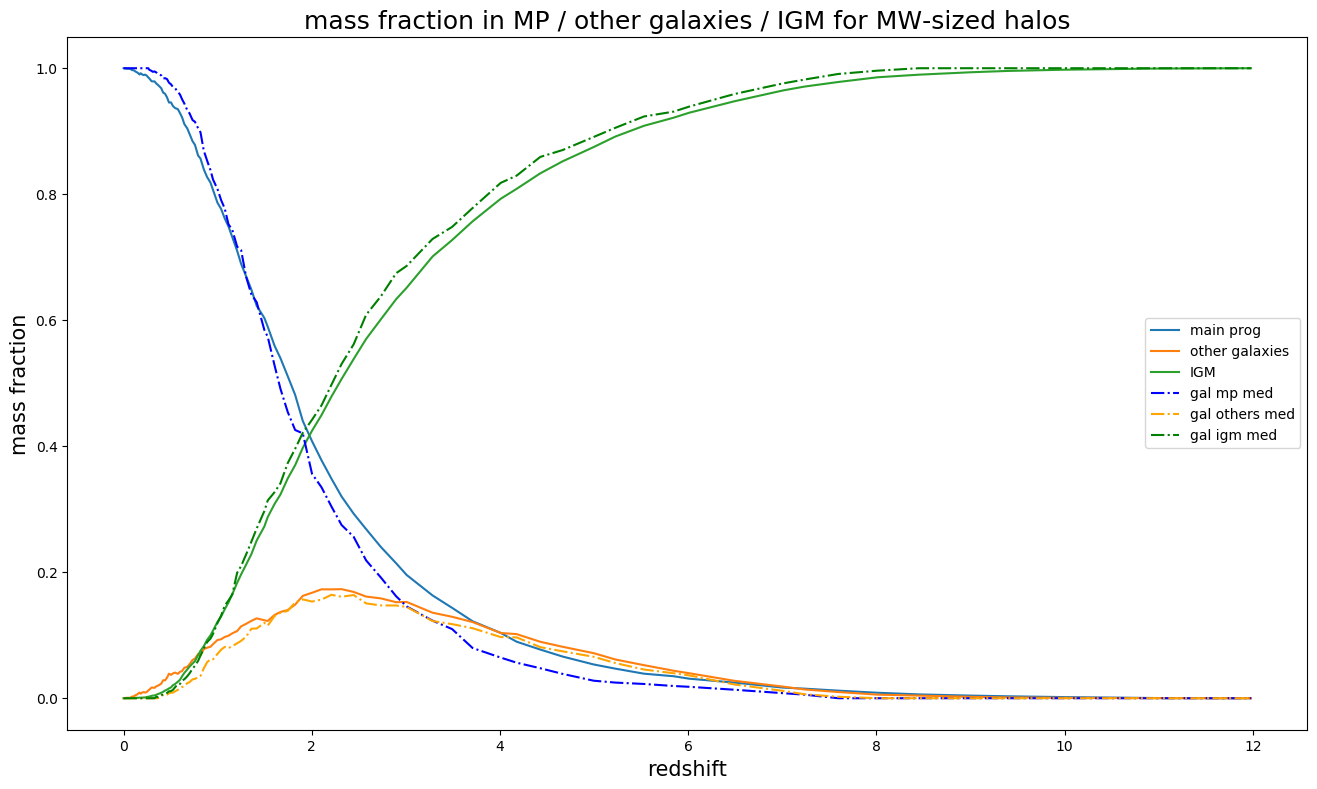

In [25]:
plt.plot(z, mp/total, label = 'main prog')
plt.plot(z, (sub - mp)/total, label = 'other galaxies')
plt.plot(z, igm/total, label = 'IGM')
plt.plot(z,np.median(gal_comp[:,:,0],axis=1),label='gal mp med',linestyle = '-.',color = 'blue')
plt.plot(z,np.median(gal_comp[:,:,1],axis=1),label='gal others med',linestyle = '-.',color = 'orange')
plt.plot(z,np.median(1 - gal_comp[:,:,0] - gal_comp[:,:,1],axis=1),label='gal igm med',linestyle = '-.',color = 'green')
plt.legend()
plt.ylabel('mass fraction',size=15)
plt.xlabel('redshift',size=15)
#plt.xticks(z)
plt.title('mass fraction in MP / other galaxies / IGM for MW-sized halos',size=18)
#plt.savefig('pics/tracer_fraction_TNG50-4_overview_mw_with_gal_comp.jpg',format='jpg')

Text(0.5, 1.0, 'mass fraction in MP / other galaxies / IGM')

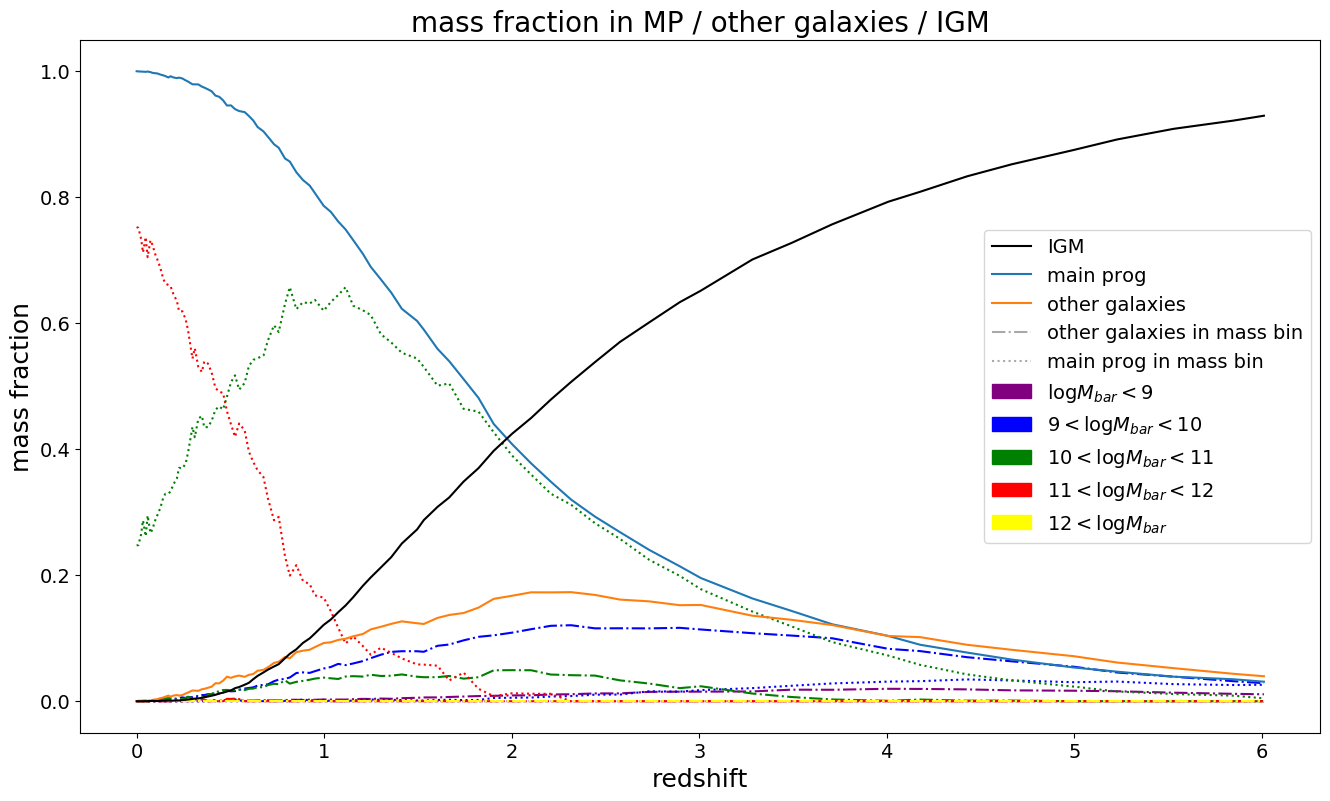

In [9]:
plt.plot(z, nums[:,0,0]/total, color = 'purple', linestyle = 'dotted', label = 'main prog')
plt.plot(z, nums[:,0,1]/total, color = 'purple', linestyle = 'dashdot', label = 'main prog')
plt.plot(z, nums[:,1,0]/total, color = 'blue', linestyle = 'dotted', label = 'main prog')
plt.plot(z, nums[:,1,1]/total, color = 'blue', linestyle = 'dashdot', label = 'main prog')
plt.plot(z, nums[:,2,0]/total, color = 'green', linestyle = 'dotted', label = 'main prog')
plt.plot(z, nums[:,2,1]/total, color = 'green', linestyle = 'dashdot', label = 'main prog')
plt.plot(z, nums[:,3,0]/total, color = 'red', linestyle = 'dotted', label = 'main prog')
plt.plot(z, nums[:,3,1]/total, color = 'red', linestyle = 'dashdot', label = 'main prog')
plt.plot(z, nums[:,4,0]/total, color = 'yellow', linestyle = 'dotted', label = 'main prog')
plt.plot(z, nums[:,4,1]/total, color = 'yellow', linestyle = 'dashdot', label = 'main prog')

plt.plot(z, mp/total, label = 'main prog')
plt.plot(z, (sub - mp)/total, label = 'other galaxies')
plt.plot(z, igm/total, color='black', label = 'IGM')

IGM = mlines.Line2D([], [], color='black', label='IGM')
MP = mlines.Line2D([], [], color='tab:blue', label='main prog')
OTHER = mlines.Line2D([], [], color='tab:orange', label='other galaxies')
dash = mlines.Line2D([], [], color='darkgray', linestyle = 'dashdot', label='other galaxies in mass bin')
dotted = mlines.Line2D([], [], color='darkgray', linestyle = 'dotted', label='main prog in mass bin')
purple = mpatches.Patch(color='purple', label='$\log{M_{bar}} < 9$')
blue = mpatches.Patch(color='blue', label='$9 < \log{M_{bar}} < 10$')
green = mpatches.Patch(color='green', label='$10 < \log{M_{bar}} < 11$')
red = mpatches.Patch(color='red', label='$11 < \log{M_{bar}} < 12$')
yellow = mpatches.Patch(color='yellow', label='$12 < \log{M_{bar}}$')

plt.legend(handles=[IGM,MP,OTHER,dash,dotted,purple,blue,green,red,yellow], fontsize = 14, loc = 'best')
plt.ylabel('mass fraction',size=18)
plt.xlabel('redshift',size=18)
plt.tick_params(labelsize = 14)
plt.title('mass fraction in MP / other galaxies / IGM',size=20)
#plt.savefig('pics/tracer_fraction_TNG50-3_everything_test.jpg',format='jpg')

### only MP

Text(0.5, 1.0, 'mass fraction in MP w/ mass bins')

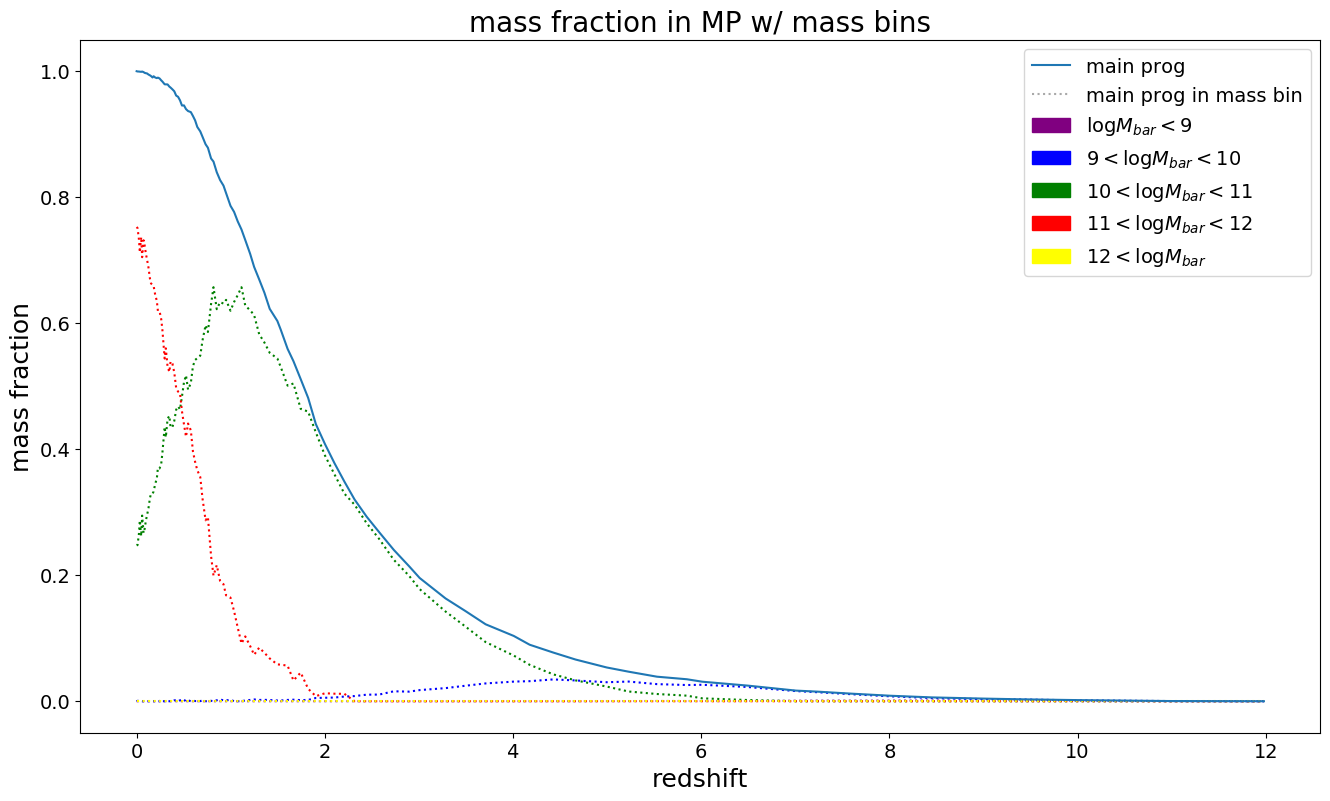

In [12]:
plt.plot(z, nums[:,0,0]/total, color = 'purple', linestyle = 'dotted', label = 'main prog')
#plt.plot(z, nums[:,0,1]/total, color = 'purple', linestyle = 'dashdot', label = 'main prog')
plt.plot(z, nums[:,1,0]/total, color = 'blue', linestyle = 'dotted', label = 'main prog')
#plt.plot(z, nums[:,1,1]/total, color = 'blue', linestyle = 'dashdot', label = 'main prog')
plt.plot(z, nums[:,2,0]/total, color = 'green', linestyle = 'dotted', label = 'main prog')
#plt.plot(z, nums[:,2,1]/total, color = 'green', linestyle = 'dashdot', label = 'main prog')
plt.plot(z, nums[:,3,0]/total, color = 'red', linestyle = 'dotted', label = 'main prog')
#plt.plot(z, nums[:,3,1]/total, color = 'red', linestyle = 'dashdot', label = 'main prog')
plt.plot(z, nums[:,4,0]/total, color = 'yellow', linestyle = 'dotted', label = 'main prog')
#plt.plot(z, nums[:,4,1]/total, color = 'yellow', linestyle = 'dashdot', label = 'main prog')

plt.plot(z, mp/total, label = 'main prog')
#plt.plot(z,np.sum(nums[:,:,0],axis = 1)/total, label = 'check sum',color = 'black')

#plt.plot(z, (sub - mp)/total, label = 'other galaxies')
#plt.plot(z, igm/total, color='black', label = 'IGM')

IGM = mlines.Line2D([], [], color='black', label='IGM')
MP = mlines.Line2D([], [], color='tab:blue', label='main prog')
OTHER = mlines.Line2D([], [], color='tab:orange', label='other galaxies')
dash = mlines.Line2D([], [], color='darkgray', linestyle = 'dashdot', label='other galaxies in mass bin')
dotted = mlines.Line2D([], [], color='darkgray', linestyle = 'dotted', label='main prog in mass bin')
purple = mpatches.Patch(color='purple', label='$\log{M_{bar}} < 9$')
blue = mpatches.Patch(color='blue', label='$9 < \log{M_{bar}} < 10$')
green = mpatches.Patch(color='green', label='$10 < \log{M_{bar}} < 11$')
red = mpatches.Patch(color='red', label='$11 < \log{M_{bar}} < 12$')
yellow = mpatches.Patch(color='yellow', label='$12 < \log{M_{bar}}$')

plt.legend(handles=[MP,dotted,purple,blue,green,red,yellow], fontsize = 14, loc = 'best')
plt.ylabel('mass fraction',size=18)
plt.xlabel('redshift',size=18)
plt.tick_params(labelsize = 14)
plt.title('mass fraction in MP w/ mass bins',size=20)
#plt.savefig('pics/tracer_fraction_TNG50-4_onlyMP_groups.jpg',format='jpg')

### only other galaxies

Text(0.5, 1.0, 'mass fraction in other galaxies w/ mass bins')

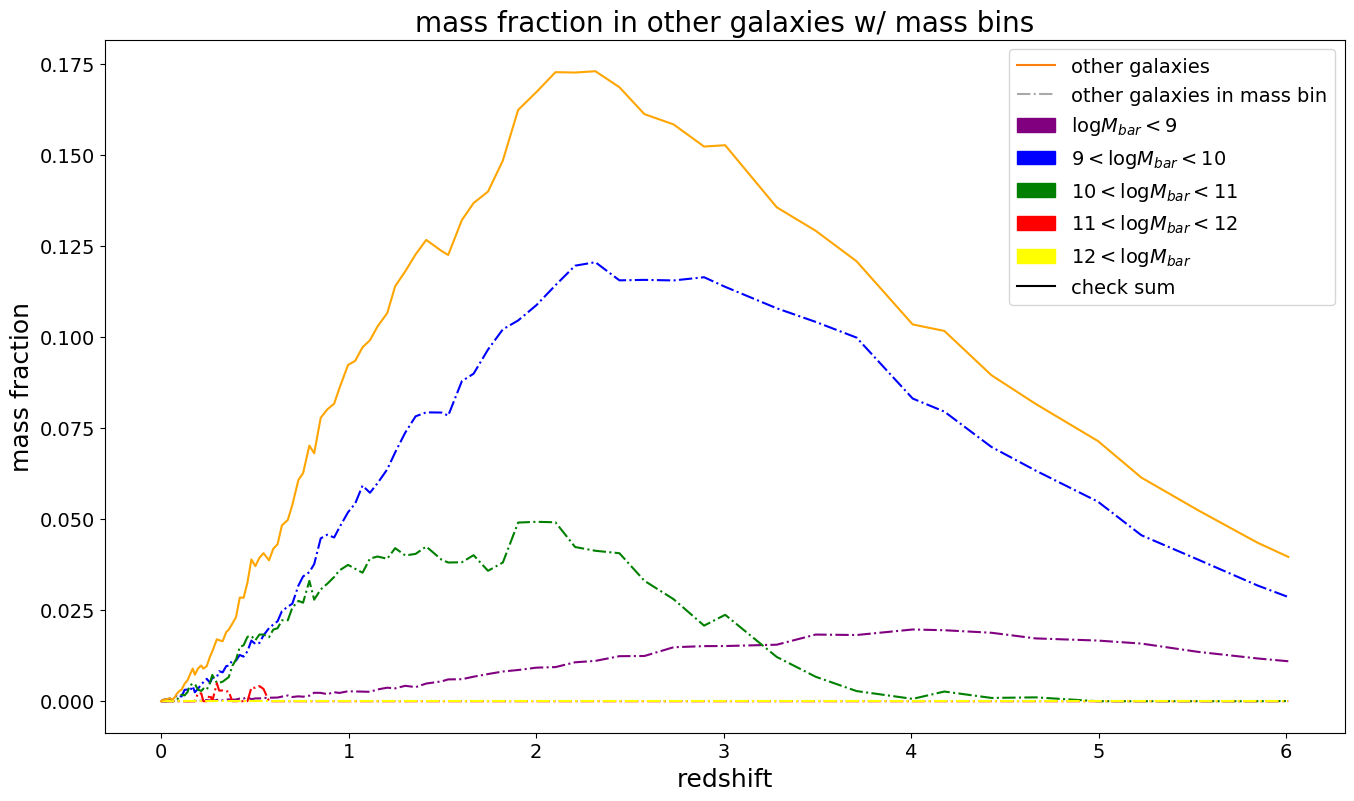

In [11]:
#plt.plot(z, nums[:,0,0]/total, color = 'purple', linestyle = 'dotted', label = 'main prog')
plt.plot(z, nums[:,0,1]/total, color = 'purple', linestyle = 'dashdot', label = 'main prog')
#plt.plot(z, nums[:,1,0]/total, color = 'blue', linestyle = 'dotted', label = 'main prog')
plt.plot(z, nums[:,1,1]/total, color = 'blue', linestyle = 'dashdot', label = 'main prog')
#plt.plot(z, nums[:,2,0]/total, color = 'green', linestyle = 'dotted', label = 'main prog')
plt.plot(z, nums[:,2,1]/total, color = 'green', linestyle = 'dashdot', label = 'main prog')
#plt.plot(z, nums[:,3,0]/total, color = 'red', linestyle = 'dotted', label = 'main prog')
plt.plot(z, nums[:,3,1]/total, color = 'red', linestyle = 'dashdot', label = 'main prog')
#plt.plot(z, nums[:,4,0]/total, color = 'yellow', linestyle = 'dotted', label = 'main prog')
plt.plot(z, nums[:,4,1]/total, color = 'yellow', linestyle = 'dashdot', label = 'main prog')

#plt.plot(z, mp/total, label = 'main prog')
plt.plot(z, (sub - mp)/total, label = 'other galaxies',color = 'orange')
#plt.plot(z,np.sum(nums[:,:,1],axis = 1)/total, label = 'check sum',color = 'black')
#plt.plot(z, igm/total, color='black', label = 'IGM')

check = mlines.Line2D([], [], color='black', label='check sum')
IGM = mlines.Line2D([], [], color='black', label='IGM')
MP = mlines.Line2D([], [], color='tab:blue', label='main prog')
OTHER = mlines.Line2D([], [], color='tab:orange', label='other galaxies')
dash = mlines.Line2D([], [], color='darkgray', linestyle = 'dashdot', label='other galaxies in mass bin')
dotted = mlines.Line2D([], [], color='darkgray', linestyle = 'dotted', label='main prog in mass bin')
purple = mpatches.Patch(color='purple', label='$\log{M_{bar}} < 9$')
blue = mpatches.Patch(color='blue', label='$9 < \log{M_{bar}} < 10$')
green = mpatches.Patch(color='green', label='$10 < \log{M_{bar}} < 11$')
red = mpatches.Patch(color='red', label='$11 < \log{M_{bar}} < 12$')
yellow = mpatches.Patch(color='yellow', label='$12 < \log{M_{bar}}$')

plt.legend(handles=[OTHER,dash,purple,blue,green,red,yellow,check], fontsize = 14, loc = 'best')
plt.ylabel('mass fraction',size=18)
plt.xlabel('redshift',size=18)
plt.tick_params(labelsize = 14)
plt.title('mass fraction in other galaxies w/ mass bins',size=20)
#plt.savefig('pics/tracer_fraction_TNG50-4_onlyOtherGalaxies_groups.jpg',format='jpg')

### galaxy composition individually:

In [33]:
def z_x_igm(gal_comp,sub_ids,z,frac):
    """for every galaxy, it determines the redshift, after which less than x % of the mass is in the igm"""
    z_igm = np.zeros(gal_comp.shape[1])
    for i in nb.prange(sub_ids.shape[0]):
        t_igm = np.min(np.where(1 - gal_comp[:,i,0] - gal_comp[:,i,1] >= frac)[0]).astype(int)
        z_igm[i] = z[t_igm]
    return z_igm

In [34]:
def z_x_mp(gal_comp,sub_ids,z,frac):
    """for every galaxy, it determines the redshift, after which more than x % of the mass is in the mpb"""
    z_mp = np.zeros(gal_comp.shape[1])
    for i in range(sub_ids.shape[0]-1):
        t_mp = np.min(np.where(gal_comp[:,i,0] <= frac)[0]).astype(int)
        z_mp[i] = z[t_mp]
    return z_mp

In [29]:
f = h5py.File('files/TNG50-4/fracs_w_mass_bins_mw.hdf5','r')
gal_comp_mw = f['galaxy_composition'][:,:,:]
z = f['redshift'][:]
sub_ids_mw = f['subhalo_ids'][:]
f.close()

f = h5py.File('files/TNG50-4/fracs_w_mass_bins_dwarves.hdf5','r')
gal_comp_dwarves = f['galaxy_composition'][:,:,:]
sub_ids_dwarves = f['subhalo_ids'][:]
f.close()

f = h5py.File('files/TNG50-4/fracs_w_mass_bins_groups.hdf5','r')
gal_comp_groups = f['galaxy_composition'][:,:,:]
sub_ids_groups = f['subhalo_ids'][:]
f.close()

In [14]:
stellar_masses_dwarves = il.groupcat.loadSubhalos(basePath, 99, fields=['SubhaloMassType'])[sub_ids_dwarves,4]\
* 1e10/h_const

stellar_masses_mw = il.groupcat.loadSubhalos(basePath, 99, fields=['SubhaloMassType'])[sub_ids_mw,4] * 1e10/h_const

stellar_masses_groups = il.groupcat.loadSubhalos(basePath, 99, fields=['SubhaloMassType'])[sub_ids_groups,4] * 1e10/h_const

In [35]:
frac_igm = 0.5
frac_mp = 0.5
z_igm_mw = z_x_igm(gal_comp_mw, sub_ids_mw, z, frac_igm)
z_mp_mw = z_x_mp(gal_comp_mw, sub_ids_mw, z, frac_mp)

z_igm_groups = z_x_igm(gal_comp_groups, sub_ids_groups, z, frac_igm)
z_mp_groups = z_x_mp(gal_comp_groups, sub_ids_groups, z, frac_mp)

z_igm_dwarves = z_x_igm(gal_comp_dwarves, sub_ids_dwarves, z, frac_igm)
z_mp_dwarves = z_x_mp(gal_comp_dwarves, sub_ids_dwarves, z, frac_mp)

percent = 100 * frac_mp

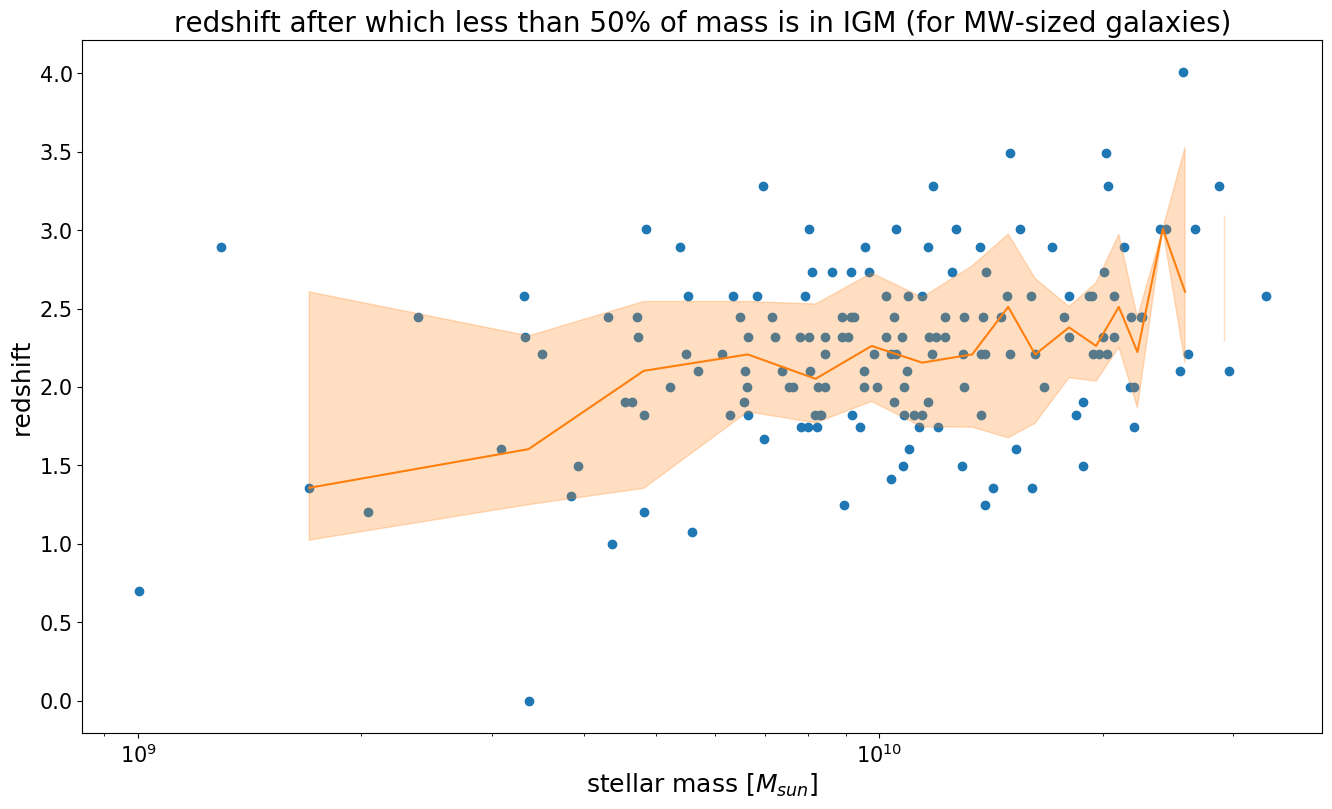

In [22]:
order = np.argsort(stellar_masses)
med = funcs.running_median_insort(z_igm,20)
xmed2, ymed2, y16, y84 = funcs.binData_med(stellar_masses,z_igm,20)

plt.scatter(stellar_masses[order],z_igm[order])
plt.plot(xmed2,ymed2,color='tab:orange')
plt.fill_between(xmed2,y16,y84,color='tab:orange',alpha=0.25)
#plt.plot(stellar_masses[order],med[order])
plt.title(f'redshift after which less than {percent:.0f}% of mass is in IGM (for MW-sized galaxies)',size=20)
plt.ylabel('redshift',size=18)
plt.xlabel('stellar mass [$M_{sun}$]', size = 18)
plt.xscale('log')
plt.tick_params(labelsize=15)
#plt.savefig(f'pics/z_{percent:.0f}_igm_mw.jpg',format = 'jpg')

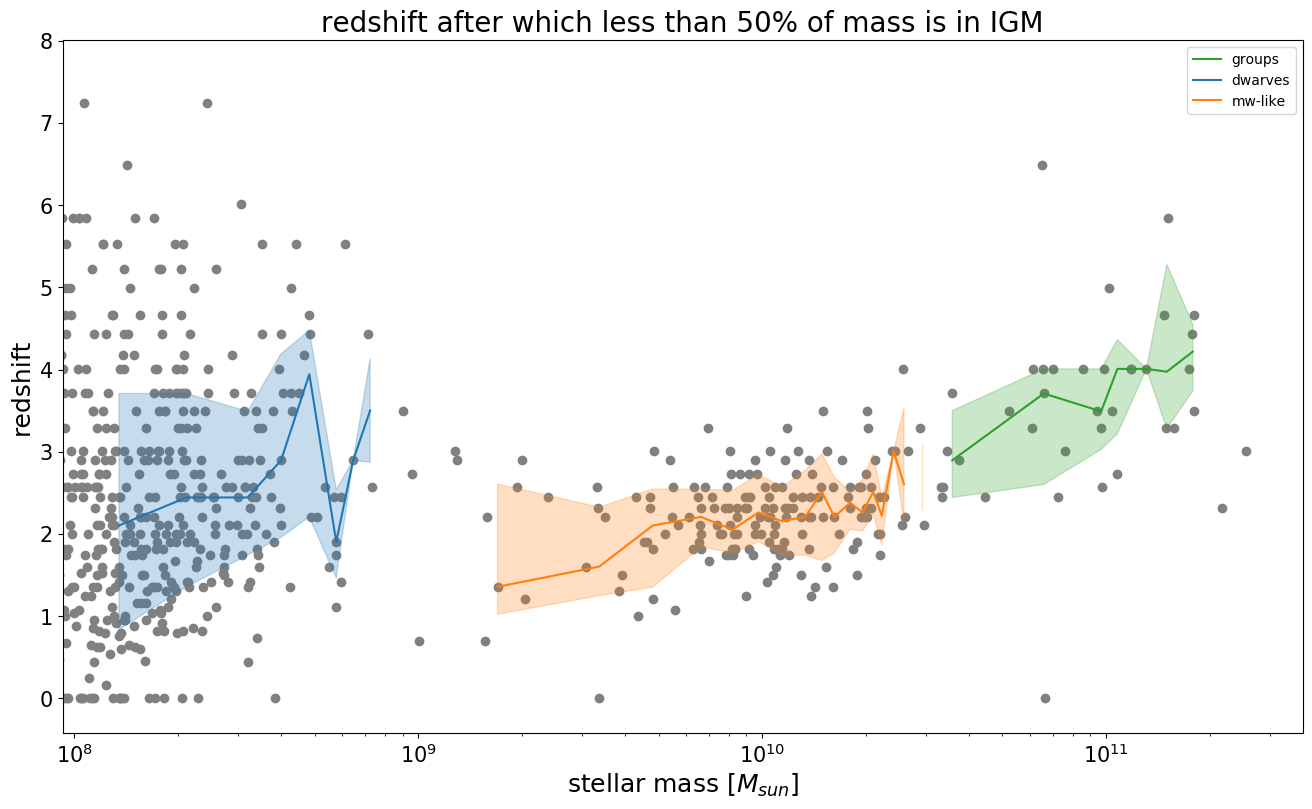

In [72]:
cond = np.where(np.logical_and(stellar_masses_dwarves > 1e8, stellar_masses_dwarves <= 1e9))[0]

xmed_groups, ymed_groups, y16_groups, y84_groups = funcs.binData_med(stellar_masses_groups, z_igm_groups, 10)
xmed_dwarves, ymed_dwarves, y16_dwarves, y84_dwarves = funcs.binData_med(stellar_masses_dwarves[cond],\
                                                                         z_igm_dwarves[cond],10)
xmed_mw, ymed_mw, y16_mw, y84_mw = funcs.binData_med(stellar_masses_mw, z_igm_mw, 20)

plt.scatter(stellar_masses_groups, z_igm_groups, color = 'gray')
plt.plot(xmed_groups, ymed_groups, color='tab:green', label = 'groups')
plt.fill_between(xmed_groups, y16_groups, y84_groups, color='tab:green', alpha=0.25)


plt.scatter(stellar_masses_dwarves, z_igm_dwarves, color = 'gray')
plt.plot(xmed_dwarves, ymed_dwarves, color='tab:blue', label = 'dwarves')
plt.fill_between(xmed_dwarves, y16_dwarves, y84_dwarves, color='tab:blue', alpha=0.25)


plt.scatter(stellar_masses_mw, z_igm_mw, color = 'gray')
plt.plot(xmed_mw, ymed_mw, color='tab:orange', label = 'mw-like')
plt.fill_between(xmed_mw, y16_mw, y84_mw, color='tab:orange', alpha=0.25)

plt.title(f'redshift after which less than {percent:.0f}% of mass is in IGM',size=20)
plt.ylabel('redshift',size=18)
plt.xlabel('stellar mass [$M_{sun}$]', size = 18)
plt.xscale('log')
plt.legend()
plt.tick_params(labelsize=15)
#plt.savefig(f'pics/z_{percent:.0f}_igm_mw.jpg',format = 'jpg')

In [47]:
order = np.argsort(stellar_masses)
#med = funcs.running_median_insort(z_igm,20)
xmed, ymed, y16, y84 = funcs.binData_med(stellar_masses,z_mp,20)

plt.scatter(stellar_masses[order],z_mp[order])
plt.plot(xmed,ymed,color='tab:orange')
plt.fill_between(xmed,y16,y84,color='tab:orange',alpha=0.25)
#plt.plot(stellar_masses[order],med[order])
plt.title(f'redshift after which more than {percent:.0f}% of mass is in the MPB (for MW-sized galaxies)',size=20)
plt.ylabel('redshift',size=18)
plt.xlabel('stellar mass [$M_{sun}$]', size = 18)
plt.xscale('log')
plt.tick_params(labelsize=15)
#plt.savefig(f'pics/z_{percent:.0f}_igm_mw.jpg',format = 'jpg')

NameError: name 'stellar_masses' is not defined

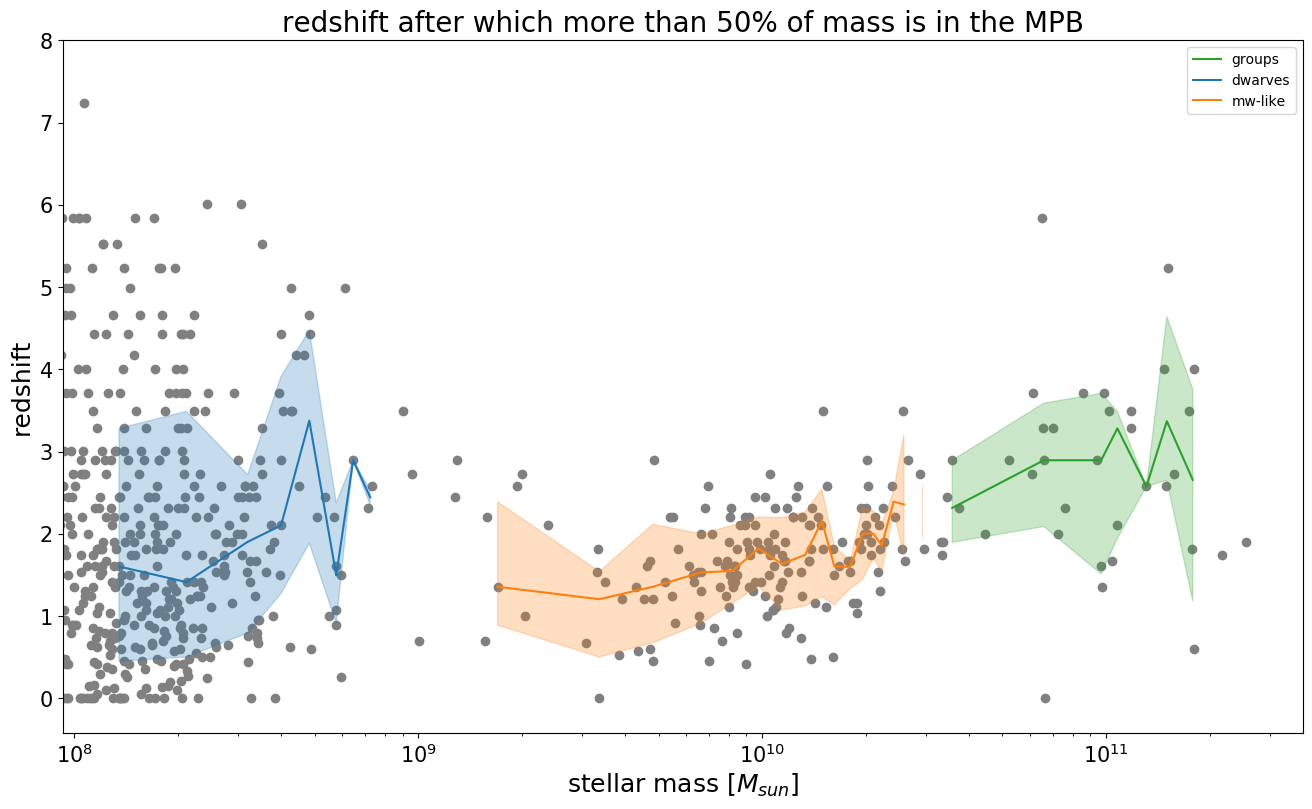

In [71]:
cond = np.where(np.logical_and(stellar_masses_dwarves > 1e8, stellar_masses_dwarves <= 1e9))[0]

xmed_groups, ymed_groups, y16_groups, y84_groups = funcs.binData_med(stellar_masses_groups, z_mp_groups, 10)
xmed_dwarves, ymed_dwarves, y16_dwarves, y84_dwarves = funcs.binData_med(stellar_masses_dwarves[cond],\
                                                                         z_mp_dwarves[cond],10)
xmed_mw, ymed_mw, y16_mw, y84_mw = funcs.binData_med(stellar_masses_mw, z_mp_mw, 20)

plt.scatter(stellar_masses_groups, z_mp_groups, color = 'gray')
plt.plot(xmed_groups, ymed_groups, color='tab:green', label = 'groups')
plt.fill_between(xmed_groups, y16_groups, y84_groups, color='tab:green', alpha=0.25)


plt.scatter(stellar_masses_dwarves, z_mp_dwarves, color = 'gray')
plt.plot(xmed_dwarves, ymed_dwarves, color='tab:blue', label = 'dwarves')
plt.fill_between(xmed_dwarves, y16_dwarves, y84_dwarves, color='tab:blue', alpha=0.25)


plt.scatter(stellar_masses_mw, z_mp_mw, color = 'gray')
plt.plot(xmed_mw, ymed_mw, color='tab:orange', label = 'mw-like')
plt.fill_between(xmed_mw, y16_mw, y84_mw, color='tab:orange', alpha=0.25)

plt.title(f'redshift after which more than {percent:.0f}% of mass is in the MPB',size=20)
plt.ylabel('redshift',size=18)
plt.xlabel('stellar mass [$M_{sun}$]', size = 18)
plt.xscale('log')
plt.legend()
plt.tick_params(labelsize=15)
#plt.savefig(f'pics/z_{percent:.0f}_mp_mw.jpg',format = 'jpg')

## compare different resolutions:

In [6]:
f = h5py.File('files/TNG50-4/fracs_w_mass_bins_mw.hdf5','r')
mp4 = f['main_progenitor'][:87]
igm4 = f['IGM'][:87]
sub4 = f['all_galaxies'][:87]
total4 = f['totals'][:87]
nums4 = f['binned_values'][:87]
z = f['redshift'][:87]
gal_comp4 = f['galaxy_composition'][:87]
f.close()

f = h5py.File('files/TNG50-3/fracs_w_mass_bins_mw_1of8.hdf5','r')
mp38 = f['main_progenitor'][:87]
igm38 = f['IGM'][:87]
sub38 = f['all_galaxies'][:87]
total38 = f['totals'][:87]
nums38 = f['binned_values'][:87]
gal_comp38 = f['galaxy_composition'][:87]
f.close()

f = h5py.File('files/TNG50-3/fracs_w_mass_bins_mw.hdf5','r')
mp3 = f['main_progenitor'][:87]
igm3 = f['IGM'][:87]
sub3 = f['all_galaxies'][:87]
total3 = f['totals'][:87]
nums3 = f['binned_values'][:87]
gal_comp3 = f['galaxy_composition'][:87]
f.close()

Text(0.5, 1.0, 'mass fraction in MP / other galaxies / IGM for MW-sized halos')

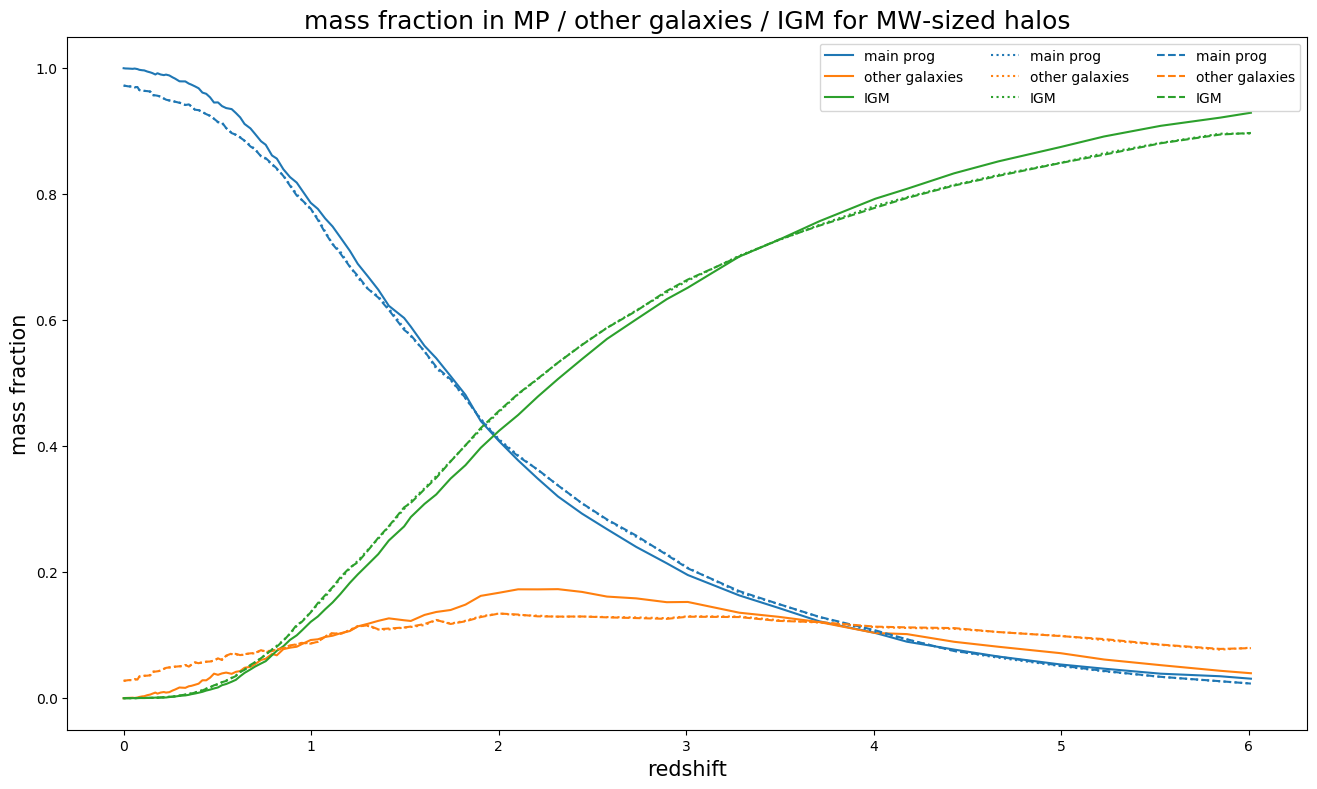

In [17]:
plt.plot(z, mp4/total4, label = 'main prog', color = 'tab:blue')
plt.plot(z, (sub4 - mp4)/total4, label = 'other galaxies', color = 'tab:orange')
plt.plot(z, igm4/total4, label = 'IGM', color = 'tab:green')

plt.plot(z, mp3/total3, label = 'main prog', color = 'tab:blue', linestyle = ':')
plt.plot(z, (sub3 - mp3)/total3, label = 'other galaxies', color = 'tab:orange', linestyle = ':')
plt.plot(z, igm3/total3, label = 'IGM', color = 'tab:green', linestyle = ':')

plt.plot(z, mp38/total38, label = 'main prog', color = 'tab:blue', linestyle = '--')
plt.plot(z, (sub38 - mp38)/total38, label = 'other galaxies', color = 'tab:orange', linestyle = '--')
plt.plot(z, igm38/total38, label = 'IGM', color = 'tab:green', linestyle = '--')
#plt.plot(z,np.median(gal_comp[:,:,0],axis=1),label='gal mp med',linestyle = '-.',color = 'blue')
#plt.plot(z,np.median(gal_comp[:,:,1],axis=1),label='gal others med',linestyle = '-.',color = 'orange')
#plt.plot(z,np.median(1 - gal_comp[:,:,0] - gal_comp[:,:,1],axis=1),label='gal igm med',linestyle = '-.',color = 'green')
plt.legend(ncol = 3)
plt.ylabel('mass fraction',size=15)
plt.xlabel('redshift',size=15)
#plt.xticks(z)
plt.title('mass fraction in MP / other galaxies / IGM for MW-sized halos',size=18)
#plt.savefig('pics/tracer_fraction_TNG50-4_overview_mw_with_gal_comp.jpg',format='jpg')

In [14]:
plt.legend?